In [1]:
import scvi
import scanpy as sc
import torch  # To run GPU
from numba import cuda    # To run GPU
import warnings
from IPython.display import display
from platform import python_version
import mygene  # For querying/mapping ensembl id -> symbol
# from pyensembl import EnsemblRelease # For querying/mapping ensembl id -> symbol
import numpy as np
import pandas as pd
from pybiomart import Dataset
import gc

print(python_version())

Global seed set to 0
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


3.9.15


### Functions

In [2]:
# execfile("group1_functions.py")
with open("group1_functions.py") as infile:
    exec(infile.read())
    

In [3]:
# # Make a function for normalisation
# # Code copied from scvi page - https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html
# def normaliseData(adata):
#   adata.layers["counts"] = adata.X.copy()  # preserve counts
#   sc.pp.normalize_total(adata, target_sum=1e4)
#   sc.pp.log1p(adata)
#   adata.raw = adata  # freeze the state in `.raw`

In [4]:
# # Make a function for reading in multiple data
# def readMultipleData(acc_key):
#   # E.g. acc_key = "GEO123456"  
#   c = 1  # Set count
#   # Create a dictionary with the name data_GEO123456 
#   d = {}
#   dict_name = "_".join(["data", acc_key])
#   globals()[dict_name] = d
#   # Define path
#   list = ["data", acc_key, "index.txt"]
#   index_path = "/".join(list)
#   with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     # Loop through files in dir and read data into dict
#     with open(index_path, 'r') as f:
#            for line in f:
#               line = line.strip()  # Get rid of /n
#               # print(line)
#               # Read in data
#               list = ["data", acc_key, line]
#               file_path = "/".join(list)
#               data = sc.read_10x_h5(file_path)
#               data.var_names_make_unique()  # Make variables unique
#               adata_name = "".join(["data", str(c)])
#               # Add adata and its name to dictionary
#               d[adata_name] = data
#               c+=1
#   # Turn dictionary keys/values into variables
#   globals().update(d)

In [5]:
# # Make a function for filtering mitochondria
# def filterByMtFrac(adata, percent):
#   adata.var['mt'] = adata.var_names.str.startswith('MT-')
#   sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)
#   # Remove cells with more than % MT
#   adata = adata[adata.obs.pct_counts_mt < percent]
#   return adata

In [6]:
ls data

EGAS00001006780/  GSE118127/  GSE184880/  GSE189960/  GSE202601/


### Datasets:
A) EGAS00001006780  <br>
B) GSE202601  <br>
C) GSE118127  <br>

### Read in datasetA: EGAS00001006780

In [7]:
!ls data/EGAS00001006780

local.h5ad		      raw_EGAS00001006780.h5ad
local.rds		      search_for_raw_counts_EGAS00001006780.R
raw_EGAS00001006780.h5Seurat  src


In [8]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dataA = sc.read_h5ad('data/EGAS00001006780/raw_EGAS00001006780.h5ad')

dataA.var_names_make_unique()

In [9]:
dataA.obs

orig.ident  nCount_RNA  nFeature_RNA  donor_id  \
AAAAACGGGCAC_1                 0       613.0           339         0   
AAAAGTCCTGCC_1                 0      1029.0           481         0   
AAAATTCCTACT_1                 0      1720.0           635         0   
AAAATTGCCAAT_1                 0       566.0           304         0   
AAACACCGATAA_1                 0       448.0           323         0   
...                          ...         ...           ...       ...   
TTTGTTGCACTAGGCC-1_6           0     10696.0          2233         5   
TTTGTTGGTATGAGAT-1_6           0      4911.0          1629         5   
TTTGTTGTCAACTGAC-1_6           0      7301.0          1972         5   
TTTGTTGTCGCATTAG-1_6           0      6037.0          1797         5   
TTTGTTGTCTCCTGAC-1_6           0      4425.0          1350         5   

                      self_reported_ethnicity_ontology_term_id  \
AAAAACGGGCAC_1                                               0   
AAAAGTCCTGCC_1                                               0   
AAAATTCCTACT_1                                               0   
AAAATTGCCAAT_1                                               0   
AAACACCGATAA_1                                               0   
...                                                        ...   
TTTGTTGCACTAGGCC-1_6                                         0   
TTTGTTGGTATGAGAT-1_6                                         0   
TTTGTTGTCAACTGAC-1_6                                         0   
TTTGTTGTCGCATTAG-1_6                                         0   
TTTGTTGTCTCCTGAC-1_6                                         0   

                      organism_ontology_term_id  sample_uuid  \
AAAAACGGGCAC_1                                0            1   
AAAAGTCCTGCC_1                                0            1   
AAAATTCCTACT_1                                0            1   
AAAATTGCCAAT_1                                0            1   
AAACACCGATAA_1                                0            1   
...                                         ...          ...   
TTTGTTGCACTAGGCC-1_6                          0            4   
TTTGTTGGTATGAGAT-1_6                          0            4   
TTTGTTGTCAACTGAC-1_6                          0            4   
TTTGTTGTCGCATTAG-1_6                          0            4   
TTTGTTGTCTCCTGAC-1_6                          0            4   

                      sample_preservation_method  tissue_ontology_term_id  \
AAAAACGGGCAC_1                                 0                        0   
AAAAGTCCTGCC_1                                 0                        0   
AAAATTCCTACT_1                                 0                        0   
AAAATTGCCAAT_1                                 0                        0   
AAACACCGATAA_1                                 0                        0   
...                                          ...                      ...   
TTTGTTGCACTAGGCC-1_6                           0                        0   
TTTGTTGGTATGAGAT-1_6                           0                        0   
TTTGTTGTCAACTGAC-1_6                           0                        0   
TTTGTTGTCGCATTAG-1_6                           0                        0   
TTTGTTGTCTCCTGAC-1_6                           0                        0   

                      development_stage_ontology_term_id  ...  expCond  \
AAAAACGGGCAC_1                                         3  ...        0   
AAAAGTCCTGCC_1                                         3  ...        0   
AAAATTCCTACT_1                                         3  ...        0   
AAAATTGCCAAT_1                                         3  ...        0   
AAACACCGATAA_1                                         3  ...        0   
...                                                  ...  ...      ...   
TTTGTTGCACTAGGCC-1_6                                   0  ...        5   
TTTGTTGGTATGAGAT-1_6                                   0  ...        5   
TTTG

In [10]:
# #dataA[dataA.var_names.str == "ENSG00000210196"]

# dataa = dataA.var['features'].str.startswith("ENSG00000211459")
# dataa = dataA[:,dataa]
# #dataa.obs
# dataa.to_df().iloc[:]

# dataa = dataB.var['gene_ids'].str.startswith("ENSG00000210082")
# dataa = dataB[:,dataa]
# dataa.var

### Read in dataset B - GSE202601

In [11]:
# !ls data/GSE202601

Merge all datasets from GSE202601

In [12]:
# Read in datasets from GSE202601
# Make sure index file is provided in dir with filenames
readMultipleData("GSE202601")
# data_GSE202601

# Make a list of all the adata objects for B and remove the first item
values = list(data_GSE202601.values())
values.pop(0)
# len(values)

# Merge
dataB = data1.concatenate(values, batch_key = "sample")
dataB

/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converte

AnnData object with n_obs × n_vars = 43494 × 33538
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

### Read in dataset C - GSE118127

In [13]:
# !ls data/GSE118127

In [14]:
# Read in datasets 
# Make sure index file is provided in dir with filenames
readMultipleData("GSE118127")

# Make a list of all the adata objects for B and remove the first item
values = list(data_GSE118127.values())
values.pop(0)
# len(values)

# Merge
dataC = data1.concatenate(values, batch_key = "sample")
dataC

/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converte

/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converte

AnnData object with n_obs × n_vars = 56206 × 33694
    obs: 'sample'
    var: 'gene_ids'

## Pre-process data

Have a quick look at the raw counts

In [15]:
# dataA.to_df().iloc[:]
# dataB.to_df().iloc[10:, 10:]
# dataC.to_df().iloc[:]

In [16]:
dataB.obs
df = pd.DataFrame(dataB.obs)
pd.set_option('display.max_rows', df.shape[0]+1)
display(df)

# Reset display options otherwise jupyter will crash
pd.set_option('display.max_rows', 25)

sample
AAACCCAAGAGTAACT-1-0      0
AAACCCAAGTATCCTG-1-0      0
AAACCCACACCTTCCA-1-0      0
AAACCCACACGACAGA-1-0      0
AAACCCACAGCGCGTT-1-0      0
AAACCCACAGGTACGA-1-0      0
AAACCCACATGAAAGT-1-0      0
AAACCCACATTACTCT-1-0      0
AAACCCACATTGGCAT-1-0      0
AAACCCAGTAGCTGAG-1-0      0
AAACCCAGTGGATGAC-1-0      0
AAACCCAGTGGTAACG-1-0      0
AAACCCATCAGATTGC-1-0      0
AAACCCATCATTTGGG-1-0      0
AAACCCATCGTGAGAG-1-0      0
AAACCCATCTGAGCAT-1-0      0
AAACGAAAGCAAACAT-1-0      0
AAACGAACACATAGCT-1-0      0
AAACGAACAGGAATAT-1-0      0
AAACGAAGTCTCTCCA-1-0      0
AAACGAAGTGAGGCAT-1-0      0
AAACGAAGTGTCACAT-1-0      0
AAACGAATCACTGTTT-1-0      0
AAACGAATCATGAGTC-1-0      0
AAACGAATCGGTGTAT-1-0      0
AAACGAATCTCAGTCC-1-0      0
AAACGAATCTTTACAC-1-0      0
AAACGCTAGCCTCAGC-1-0      0
AAACGCTAGTAGCAAT-1-0      0
AAACGCTAGTGAATAC-1-0      0
AAACGCTCACATGTTG-1-0      0
AAACGCTGTACCATAC-1-0      0
AAACGCTGTATGACAA-1-0      0
AAACGCTGTCGAAGCA-1-0      0
AAACGCTGTCGAGTGA-1-0      0
AAACGCTGTCGGTGTC-1-0      0
AAACGCTGTGTCTTGA-1-0      0
AAACGCTGTTGGTAGG-1-0      0
AAACGCTTCGAGATAA-1-0      0
AAACGCTTCGCTGACG-1-0      0
AAACGCTTCTGCCCTA-1-0      0
AAAGAACAGGATTACA-1-0      0
AAAGAACCACCAGCTG-1-0      0
AAAGAACCACTCTCGT-1-0      0
AAAGAACGTGAGTCAG-1-0      0
AAAGAACTCCTACGGG-1-0      0
AAAGAACTCGCTTGAA-1-0      0
AAAGAACTCGGTGTAT-1-0      0
AAAGGATAGCCACAAG-1-0      0
AAAGGATAGCCATGCC-1-0      0
AAAGGATCACAACGTT-1-0      0
AAAGGATCACCAGTTA-1-0      0
AAAGGATCATAATGAG-1-0      0
AAAGGATGTTAGAAGT-1-0      0
AAAGGATTCTGTCGTC-1-0      0
AAAGGGCAGGTTGAGC-1-0      0
AAAGGGCCACACGTGC-1-0      0
AAAGGGCCACCGCTGA-1-0      0
AAAGGGCCAGATCACT-1-0      0
AAAGGGCCATACCAGT-1-0      0
AAAGGGCCATCAGCGC-1-0      0
AAAGGGCGTAGACGGT-1-0      0
AAAGGGCGTAGCCAGA-1-0      0
AAAGGGCGTGGCATCC-1-0      0
AAAGGGCTCAAACGTC-1-0      0
AAAGGGCTCAAAGACA-1-0      0
AAAGGGCTCAACTCTT-1-0      0
AAAGGGCTCAGGAACG-1-0      0
AAAGGGCTCATTCACT-1-0      0
AAAGGGCTCGTGGCGT-1-0      0
AAAGGGCTCTGGGCCA-1-0      0
AAAGGTAAGTGCACTT-1-0      0
AAAGGTACACCACTGG-1-0      0
AAAGGTACACTTCATT-1-0      0
AAAGGTACAGATCCAT-1-0      0
AAAGGTAGTCTAGATC-1-0      0
AAAGGTAGTTGTACGT-1-0      0
AAAGGTATCAGGACGA-1-0      0
AAAGGTATCGTGGCTG-1-0      0
AAAGTCCAGAGTCAAT-1-0      0
AAAGTCCAGGGTTGCA-1-0      0
AAAGTCCCAGTAACAA-1-0      0
AAAGTCCCATTAGGCT-1-0      0
AAAGTCCGTAAGAACT-1-0      0
AAAGTCCGTGCATGAG-1-0      0
AAAGTCCTCAATCTTC-1-0      0
AAAGTCCTCAGCGTCG-1-0      0
AAAGTCCTCCCGTTCA-1-0      0
AAAGTCCTCGGCCTTT-1-0      0
AAAGTGAAGATTGTGA-1-0      0
AAAGTGAAGTTGGAAT-1-0      0
AAAGTGACACGTATAC-1-0      0
AAAGTGACAGAGGTTG-1-0      0
AAAGTGACAGTTGTCA-1-0      0
AAAGTGAGTCCAGCCA-1-0      0
AAAGTGAGTCGAATTC-1-0      0
AAAGTGATCATCGGGC-1-0      0
AAAGTGATCGAGCCTG-1-0      0
AAATGGAAGAAGTCCG-1-0      0
AAATGGAAGCATTTCG-1-0      0
AAATGGAAGGACACTG-1-0      0
AAATGGAAGTCTGCGC-1-0      0
AAATGGACATCGCTCT-1-0      0
AAATGGATCTCTTAAC-1-0      0
AACAAAGAGCGCATCC-1-0      0
AACAAAGAGCTCCACG-1-0      0
AACAAAGCACCTCTGT-1-0      0
AACAAAGTCAAGGTGG-1-0      0
AACAAAGTCGAAGTGG-1-0      0
AACAAAGTCGTTATCT-1-0      0
AACAAAGTCTTTCGAT-1-0      0
AACAACCCAGAGTGTG-1-0      0
AACAACCGTATGGAGC-1-0      0
AACAACCGTCTGTGCG-1-0      0
AACAACCGTGTGATGG-1-0      0
AACAACCTCAAGCCAT-1-0      0
AACAACCTCATGCCAA-1-0      0
AACAAGAAGCGGGTAT-1-0      0
AACAAGAAGCTGTTAC-1-0      0
AACAAGAAGGAGATAG-1-0      0
AACAAGACAAACGTGG-1-0      0
AACAAGACACTTCATT-1-0      0
AACAAGAGTTCCTAGA-1-0      0
AACAAGATCTATGTGG-1-0      0
AACAAGATCTGGGATT-1-0      0
AACACACAGGTACCTT-1-0      0
AACACACCACATGGTT-1-0      0
AACACACCACCAACAT-1-0      0
AACACACCACTTACAG-1-0      0
AACACACCAGAGGTTG-1-0      0
AACACACCAGCCGGTT-1-0      0
AACACACGTCCACAGC-1-0      0
AACACACGTGAACTAA-1-0      0
AACACACGTTGCCATA-1-0      0
AACACACTCACGGGAA-1-0      0
AACACACTCAGAATAG-1-0      0
AACACACTCCATTGCC-1-0      0
AACACACTCTTGGGCG-1-0      0
AACAGGGAGAGCCCAA-1-0      0
AACAGGGAGCAATAAC-1-0      0
AACAGGGCAAACACCT-1-0      0
AACAGGGCAAGTCCAT-1-0      0
AACAGGGCACGGAAGT-

In [17]:
# Display dimensions of all datasets simultaneously
# If shape = (x,y), number of cells is x = (no. of cells, no. of genes)
display(dataA.shape)
display(dataB.shape)
display(dataC.shape)

(26134, 60185)

(43494, 33538)

(56206, 33694)

### Filter cells

In [18]:
# filter
datasets = [dataA, dataB, dataC]

for i in datasets:
   dataset = i
   sc.pp.filter_cells(dataset,min_genes = 100)
   sc.pp.filter_genes(dataset,min_cells = 3)

In [19]:
display(dataA.shape)
display(dataB.shape)
display(dataC.shape)

(26134, 26002)

(43493, 27315)

(56202, 22819)

To filter cells with a high percentage of mitochondria we need to find mitchondrial genes. Make sure the var_names are the gene symbols so we can search for genes beginning with 'MT-'.

In [20]:
# Have a look at var_names for each dataset
display(dataA.var_names[0:5])
display(dataB.var_names[0:5])
display(dataC.var_names[0:5])

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460'],
      dtype='object')

Index(['AL627309.1', 'AL627309.2', 'AC114498.1', 'AL669831.2', 'AL669831.5'], dtype='object')

Index(['RP11-34P13.7', 'FO538757.2', 'AP006222.2', 'RP4-669L17.10',
       'RP5-857K21.4'],
      dtype='object')

In [21]:
# dataA.var

In [22]:
dataA.obs

orig.ident  nCount_RNA  nFeature_RNA  donor_id  \
AAAAACGGGCAC_1                 0       613.0           339         0   
AAAAGTCCTGCC_1                 0      1029.0           481         0   
AAAATTCCTACT_1                 0      1720.0           635         0   
AAAATTGCCAAT_1                 0       566.0           304         0   
AAACACCGATAA_1                 0       448.0           323         0   
...                          ...         ...           ...       ...   
TTTGTTGCACTAGGCC-1_6           0     10696.0          2233         5   
TTTGTTGGTATGAGAT-1_6           0      4911.0          1629         5   
TTTGTTGTCAACTGAC-1_6           0      7301.0          1972         5   
TTTGTTGTCGCATTAG-1_6           0      6037.0          1797         5   
TTTGTTGTCTCCTGAC-1_6           0      4425.0          1350         5   

                      self_reported_ethnicity_ontology_term_id  \
AAAAACGGGCAC_1                                               0   
AAAAGTCCTGCC_1                                               0   
AAAATTCCTACT_1                                               0   
AAAATTGCCAAT_1                                               0   
AAACACCGATAA_1                                               0   
...                                                        ...   
TTTGTTGCACTAGGCC-1_6                                         0   
TTTGTTGGTATGAGAT-1_6                                         0   
TTTGTTGTCAACTGAC-1_6                                         0   
TTTGTTGTCGCATTAG-1_6                                         0   
TTTGTTGTCTCCTGAC-1_6                                         0   

                      organism_ontology_term_id  sample_uuid  \
AAAAACGGGCAC_1                                0            1   
AAAAGTCCTGCC_1                                0            1   
AAAATTCCTACT_1                                0            1   
AAAATTGCCAAT_1                                0            1   
AAACACCGATAA_1                                0            1   
...                                         ...          ...   
TTTGTTGCACTAGGCC-1_6                          0            4   
TTTGTTGGTATGAGAT-1_6                          0            4   
TTTGTTGTCAACTGAC-1_6                          0            4   
TTTGTTGTCGCATTAG-1_6                          0            4   
TTTGTTGTCTCCTGAC-1_6                          0            4   

                      sample_preservation_method  tissue_ontology_term_id  \
AAAAACGGGCAC_1                                 0                        0   
AAAAGTCCTGCC_1                                 0                        0   
AAAATTCCTACT_1                                 0                        0   
AAAATTGCCAAT_1                                 0                        0   
AAACACCGATAA_1                                 0                        0   
...                                          ...                      ...   
TTTGTTGCACTAGGCC-1_6                           0                        0   
TTTGTTGGTATGAGAT-1_6                           0                        0   
TTTGTTGTCAACTGAC-1_6                           0                        0   
TTTGTTGTCGCATTAG-1_6                           0                        0   
TTTGTTGTCTCCTGAC-1_6                           0                        0   

                      development_stage_ontology_term_id  ...  percent.mt  \
AAAAACGGGCAC_1                                         3  ...   12.071778   
AAAAGTCCTGCC_1                                         3  ...   17.298348   
AAAATTCCTACT_1                                         3  ...   14.069767   
AAAATTGCCAAT_1                                         3  ...   18.374558   
AAACACCGATAA_1                                         3  ...   14.508929   
...                                                  ...  ...         ...   
TTTGTTGCACTAGGCC-1_6                                   0  ...    7.292446   
TTTGTTGGTATGAGAT-1_6                                  

We can see that there is another column with ensembl ids in. Get symbols for dataA using mygene tool, then ensembl ids with symbols for var_names.

In [23]:
# df =dataset.list_attributes()
# pd.set_option('display.max_rows', df.shape[0]+1)

In [24]:
# Create a map for ensembl id and symbols
dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://www.ensembl.org')

query = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])

# Set index of our query dataset to ensembl id to be consistent with dataA's index
query.index = query["Gene stable ID"]

# Check for duplicates in index
dup = query.index.duplicated()
display(sum(dup))
query = query[~dup]  # get rid of dups

# Subset the query to view a subset of mitochondrial genes and see if they start with MT-
mtGenes = ["ENSG00000198888","ENSG00000198763","ENSG00000198804","ENSG00000198712","ENSG00000228253"]
query[query['Gene stable ID'].isin(mtGenes)]  # Check if a subset mitochondrial genes are there

0

Gene stable ID Gene name
Gene stable ID                            
ENSG00000198888  ENSG00000198888    MT-ND1
ENSG00000198763  ENSG00000198763    MT-ND2
ENSG00000198804  ENSG00000198804    MT-CO1
ENSG00000198712  ENSG00000198712    MT-CO2
ENSG00000228253  ENSG00000228253   MT-ATP8

These labels are what we want. Add these to dataset A to filter out cells with a high percent of mitochondrial genes.

In [25]:
# Inset symbols in column 0 of dataA, then make these into var_names
dataA.var.insert(0, "symbol", query['Gene name'], True)
dataA.var_names = dataA.var.symbol
dataA.var

symbol         features  n_cells
symbol                                      
TSPAN6      TSPAN6  ENSG00000000003     4294
TNMD          TNMD  ENSG00000000005      190
DPM1          DPM1  ENSG00000000419     3767
SCYL3        SCYL3  ENSG00000000457      531
C1orf112  C1orf112  ENSG00000000460      150
...            ...              ...      ...
NaN            NaN  ENSG00000288187       22
FAM106C    FAM106C  ENSG00000288235       17
NaN            NaN  ENSG00000288253      208
NaN            NaN  ENSG00000288302       18
NaN            NaN  ENSG00000288398       82

[26002 rows x 3 columns]

In [26]:
# Get a subset of mitogenes to filter out (ribosomal and tranfer)
# We want to leave in 

# Get mitochondrial genes from the HGNC website
mito_all_url = "https://www.genenames.org/cgi-bin/genegroup/download?id=1972&type=branch"
mito_pcoding_url = "https://www.genenames.org/cgi-bin/genegroup/download?id=1974&type=node"

# Get mt gene tables
mito_all_genes = pd.read_table( mito_all_url, header=[0])
mito_pcoding_genes = pd.read_table( mito_pcoding_url, header=[0])

# Get the gene names in a string
mpcg=mito_pcoding_genes.iloc[:,1]
mag=mito_all_genes.iloc[:,1]

# Filter for mt genes we want to filter out
mt_filter = mito_all_genes[~mag.isin(mpcg)].iloc[:,1]

# Create mask for mt genes we want to filter out
mt_mk = np.in1d( dataA.var_names.values.astype(str), mt_filter)

# Filter out of dataA
dataA = dataA[:,~mt_mk]
dataA

View of AnnData object with n_obs × n_vars = 26134 × 25987
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'expCond', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'n_genes'
    var: 'symbol', 'features', 'n_cells'

In [27]:
# Check for mitochondrial genes in dataA
# Untidy, but works
# mito = dataA.var_names.str.startswith('MT-')
# mito = mito.tolist()
# mito = pd.DataFrame(mito, columns = ['mito'])
# mito = mito.replace(np.nan, False)
# mito = mito.mito.tolist()
# datamito = dataA[:,mito]
# datamito.var

In [28]:
# mito = dataB.var_names.str.startswith('MT-')
# mito = mito.tolist()
# mito = pd.DataFrame(mito, columns = ['mito'])
# mito = mito.replace(np.nan, False)
# mito = mito.mito.tolist()
# datamito = dataB[:,mito]
# datamito.var

Make sure all of the datasets contain the same number of mitochondrial genes. This is important to ensure consistancy for the mitochondrial percentage filtering.

In [29]:
# Check how many mitochondrial genes we have in each dataset
mito = dataA.var_names.str.startswith('MT-')
display(np.nansum(mito))  # ignore the NaNs
mito = dataB.var_names.str.startswith('MT-')
display(np.nansum(mito))
mito = dataC.var_names.str.startswith('MT-')
display(np.nansum(mito))

13

13

13

In [30]:
# # Have a look at all the mitchondial genes in dataB
# keep = dataB.var_names.str.startswith('MT-')
# remove = np.invert(keep)
# dataBMT = dataB[:,keep]
# dataBMT.var['gene_ids']
# #len(dataBMT.var_names)

In [31]:
display(dataA.shape)
display(dataB.shape)
display(dataC.shape)

(26134, 25987)

(43493, 27315)

(56202, 22819)

In [32]:
dataA.var_names = dataA.var['symbol'].replace(np.nan, 'NaN')

/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:896: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_index(names, "var")


In [33]:
# Remove cells with more than % MT
# dataA = dataA[dataA.obs['percent.mt'] < 15]
dataA = filterByMtFrac(dataA, 15)
dataB = filterByMtFrac(dataB, 15)
dataC = filterByMtFrac(dataC, 15)

Compare their calculated percent per mitochondria to ours... interestingly there is a massive difference for donor 0, but not a large difference for donor 6.

In [34]:
pd.DataFrame(dataA.obs, columns = ['percent.mt','pct_counts_mt'])

percent.mt  pct_counts_mt
AAAAACGGGCAC_1         12.071778       3.231598
AAAAGTCCTGCC_1         17.298348       3.280543
AAAATTCCTACT_1         14.069767       1.334223
AAAATTGCCAAT_1         18.374558       3.757829
AAACACCGATAA_1         14.508929       1.282051
...                          ...            ...
TTTGTTGCACTAGGCC-1_6    7.292446       7.293128
TTTGTTGGTATGAGAT-1_6   12.706170      12.708757
TTTGTTGTCAACTGAC-1_6    6.848377       6.851192
TTTGTTGTCGCATTAG-1_6    4.969356       4.971003
TTTGTTGTCTCCTGAC-1_6    7.141243       7.144472

[25060 rows x 2 columns]

In [35]:
dataC.var

gene_ids  n_cells     mt  n_cells_by_counts  \
RP11-34P13.7   ENSG00000238009       23  False                 23   
FO538757.2     ENSG00000279457     2690  False               2690   
AP006222.2     ENSG00000228463     1498  False               1498   
RP4-669L17.10  ENSG00000237094       69  False                 69   
RP5-857K21.4   ENSG00000230021       24  False                 24   
...                        ...      ...    ...                ...   
AC007325.4     ENSG00000278817      298  False                298   
AC007325.2     ENSG00000277196        3  False                  3   
AL354822.1     ENSG00000278384       91  False                 91   
AC004556.1     ENSG00000276345      230  False                230   
AC240274.1     ENSG00000271254      740  False                740   

               mean_counts  pct_dropout_by_counts  total_counts  
RP11-34P13.7      0.000409              99.959076          23.0  
FO538757.2        0.051760              95.213693        2909.0  
AP006222.2        0.028059              97.334614        1577.0  
RP4-669L17.10     0.001228              99.877229          69.0  
RP5-857K21.4      0.000427              99.957297          24.0  
...                    ...                    ...           ...  
AC007325.4        0.005409              99.469770         304.0  
AC007325.2        0.000053              99.994662           3.0  
AL354822.1        0.001637              99.838084          92.0  
AC004556.1        0.004324              99.590762         243.0  
AC240274.1        0.013843              98.683321         778.0  

[22819 rows x 7 columns]

In [36]:
# Make ens id the var_names ens whilst keeping the old symbol names in a new column
dataA.var_names = dataA.var['features']

dataB.var.insert(0, "old_symbols", dataB.var_names, True)
dataB.var_names = dataB.var['gene_ids']

dataC.var.insert(0, "old_symbols", dataC.var_names, True)
dataC.var_names = dataC.var['gene_ids']

/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Try merging datasets at this point

In [37]:
datasets = [dataB,dataC]
adata = dataA.concatenate(datasets, batch_key = "dataset")

# adata = adata.concatenate(dataC, batch_key = "dataset")
# dataB = data1.concatenate(values, batch_key = "sample")

/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [An

In [ ]:
# Change dataset labels to dataset names
old_to_new = {'0':'EGAS00001006780', '1':'GSE202601','2':'GSE118127'}
old_to_new

adata.obs['dataset'] = (
    adata.obs['dataset']
    .map(old_to_new)
    .astype('category')
)
adata.obs

In [38]:
adata

AnnData object with n_obs × n_vars = 123877 × 20008
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'expCond', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'dataset'
    var: 'mt', 'symbol-0', 'features-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_cou

In [39]:
# # # Check that datasets are labelled correctly
# # df = pd.DataFrame(adata.obs['dataset'])
# df = pd.DataFrame(adata.obs['sample'])
# pd.set_option('display.max_rows', df.shape[0]+1)
# display(df)

# # # Reset display options otherwise jupyter will crash
# pd.set_option('display.max_rows', 25)

In [40]:
normaliseData(adata)

In [114]:
# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=1200,
#     subset=True,
#     layer="counts",
#     flavor="seurat_v3",
#     batch_key="dataset",
# )

# scHarm uses 3000 var genes, so try with this
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="dataset",
)

In [42]:
adata.obs

orig.ident  nCount_RNA  nFeature_RNA  donor_id  \
AAAAACGGGCAC_1-0                0.0       613.0         339.0       0.0   
AAAAGTCCTGCC_1-0                0.0      1029.0         481.0       0.0   
AAAATTCCTACT_1-0                0.0      1720.0         635.0       0.0   
AAAATTGCCAAT_1-0                0.0       566.0         304.0       0.0   
AAACACCGATAA_1-0                0.0       448.0         323.0       0.0   
...                             ...         ...           ...       ...   
TTGACTTCATAGGATA-1-30-2         NaN         NaN           NaN       NaN   
TTGCGTCCAACAACCT-1-30-2         NaN         NaN           NaN       NaN   
TTGGAACTCGGCTACG-1-30-2         NaN         NaN           NaN       NaN   
TTTACTGCACCGGAAA-1-30-2         NaN         NaN           NaN       NaN   
TTTGTCAGTAGCACGA-1-30-2         NaN         NaN           NaN       NaN   

                         self_reported_ethnicity_ontology_term_id  \
AAAAACGGGCAC_1-0                                              0.0   
AAAAGTCCTGCC_1-0                                              0.0   
AAAATTCCTACT_1-0                                              0.0   
AAAATTGCCAAT_1-0                                              0.0   
AAACACCGATAA_1-0                                              0.0   
...                                                           ...   
TTGACTTCATAGGATA-1-30-2                                       NaN   
TTGCGTCCAACAACCT-1-30-2                                       NaN   
TTGGAACTCGGCTACG-1-30-2                                       NaN   
TTTACTGCACCGGAAA-1-30-2                                       NaN   
TTTGTCAGTAGCACGA-1-30-2                                       NaN   

                         organism_ontology_term_id  sample_uuid  \
AAAAACGGGCAC_1-0                               0.0          1.0   
AAAAGTCCTGCC_1-0                               0.0          1.0   
AAAATTCCTACT_1-0                               0.0          1.0   
AAAATTGCCAAT_1-0                               0.0          1.0   
AAACACCGATAA_1-0                               0.0          1.0   
...                                            ...          ...   
TTGACTTCATAGGATA-1-30-2                        NaN          NaN   
TTGCGTCCAACAACCT-1-30-2                        NaN          NaN   
TTGGAACTCGGCTACG-1-30-2                        NaN          NaN   
TTTACTGCACCGGAAA-1-30-2                        NaN          NaN   
TTTGTCAGTAGCACGA-1-30-2                        NaN          NaN   

                         sample_preservation_method  tissue_ontology_term_id  \
AAAAACGGGCAC_1-0                                0.0                      0.0   
AAAAGTCCTGCC_1-0                                0.0                      0.0   
AAAATTCCTACT_1-0                                0.0                      0.0   
AAAATTGCCAAT_1-0                                0.0                      0.0   
AAACACCGATAA_1-0                                0.0                      0.0   
...                                             ...                      ...   
TTGACTTCATAGGATA-1-30-2                         NaN                      NaN   
TTGCGTCCAACAACCT-1-30-2                         NaN                      NaN   
TTGGAACTCGGCTACG-1-30-2                         NaN                      NaN   
TTTACTGCACCGGAAA-1-30-2                         NaN                      NaN   
TTTGTCAGTAGCACGA-1-30-2                         NaN                      NaN   

                         development_stage_ontology_term_id  ...  tissue  \
AAAAACGGGCAC_1-0                                        3.0  ...     0.0   
AAAAGTCCTGCC_1-0                                        3.0  ...     0.0   
AAAATTCCTACT_1-0                                        3.0  ...     0.0   
AAAATTGCCAAT_1-0                                        3.0  ...     0.0   
AAACACCGATAA_1-0                                        3.0  ...     0.0   
...                                                     ...  ...     ... 

In [43]:
import torch  # To run GPU
from numba import cuda    # To run GPU

In [116]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts", categorical_covariate_keys=["dataset"], continuous_covariate_keys=['pct_counts_mt','total_counts'])

In [ ]:
torch.cuda.is_available()
#torch.cuda.current_device()

In [63]:
def select_gpu(whichGPU):
    gpu=""
    if(whichGPU=="0"):
        print("here0")
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        gpu="cuda:0"
    elif(whichGPU=="1"):
        print("here1")
        device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        gpu="cuda:1"
    elif(whichGPU=="2"):
        print("here2")
        device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
        gpu="cuda:2"
    elif(whichGPU=="3"):
        print("here3")
        device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
        gpu="cuda:3"
    return device

In [69]:
#device = select_gpu("1")
#select_gpu("3")

here3


device(type='cuda', index=3)

In [55]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
gpu="cuda:2"
torch.cuda.set_device(device)

In [71]:
torch.cuda.current_device()

2

In [73]:
gc.collect()

2427

In [117]:
model = scvi.model.SCVI(adata)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [118]:
# train the model
# model.train().torch.device
model2.train().torch.device

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 65/65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [10:33<00:00, 10.01s/it, loss=222, v_num=1]

`Trainer.fit` stopped: `max_epochs=65` reached.


Epoch 65/65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [10:33<00:00,  9.75s/it, loss=222, v_num=1]


AttributeError: 'NoneType' object has no attribute 'torch'

In [119]:
model2

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained

In [120]:
# Save model
# model.save('group1_training_model.pt')
# model

model2.save('group1_training_model2.pt')
model = model2

In [121]:
# Extract latent representation of the data (numpy array of length of dataset)

# latent = model.get_latent_representation()
# latent.shape

latent = model.get_latent_representation()
latent.shape

(123877, 10)

In [123]:
adata.obsm['X_scVI'] = latent

In [124]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [125]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

In [ ]:
# Leiden is saved as a new column
# adata.obs

/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/well/lindgren/users/mzf347/conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


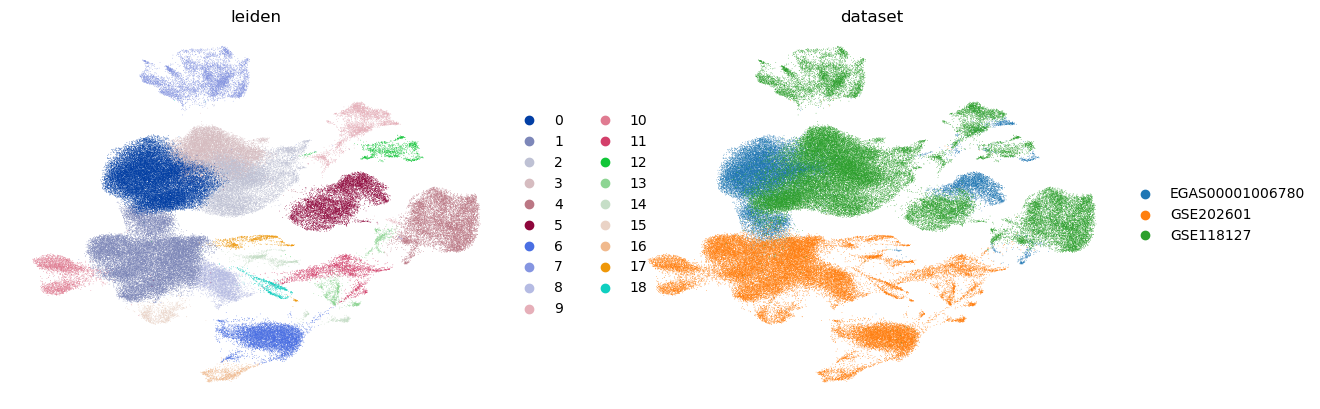

In [126]:
# Plot the UMAPs
sc.pl.umap(adata, color = ['leiden', 'dataset'], frameon = False)

In [109]:
# dataA.obs.iloc[0:3,]

df = pd.DataFrame(dataA.obs.iloc[0:3,])
pd.set_option('display.max_rows', df.shape[0]+1)
display(df)

# Reset display options otherwise jupyter will crash
pd.set_option('display.max_rows', 25)

orig.ident  nCount_RNA  nFeature_RNA  donor_id  \
AAAAACGGGCAC_1           0       613.0           339         0   
AAAAGTCCTGCC_1           0      1029.0           481         0   
AAAATTCCTACT_1           0      1720.0           635         0   

                self_reported_ethnicity_ontology_term_id  \
AAAAACGGGCAC_1                                         0   
AAAAGTCCTGCC_1                                         0   
AAAATTCCTACT_1                                         0   

                organism_ontology_term_id  sample_uuid  \
AAAAACGGGCAC_1                          0            1   
AAAAGTCCTGCC_1                          0            1   
AAAATTCCTACT_1                          0            1   

                sample_preservation_method  tissue_ontology_term_id  \
AAAAACGGGCAC_1                           0                        0   
AAAAGTCCTGCC_1                           0                        0   
AAAATTCCTACT_1                           0                        0   

                development_stage_ontology_term_id  ...  organism  sex  \
AAAAACGGGCAC_1                                   3  ...         0    0   
AAAAGTCCTGCC_1                                   3  ...         0    0   
AAAATTCCTACT_1                                   3  ...         0    0   

                tissue  self_reported_ethnicity  development_stage  n_genes  \
AAAAACGGGCAC_1       0                        0                  3      341   
AAAAGTCCTGCC_1       0                        0                  3      486   
AAAATTCCTACT_1       0                        0                  3      640   

                n_genes_by_counts  total_counts  total_counts_mt  \
AAAAACGGGCAC_1                338         557.0             18.0   
AAAAGTCCTGCC_1                483         884.0             29.0   
AAAATTCCTACT_1                634        1499.0             20.0   

                pct_counts_mt  
AAAAACGGGCAC_1       3.231598  
AAAAGTCCTGCC_1       3.280543  
AAAATTCCTACT_1       1.334223  

[3 rows x 35 columns]

In [113]:
dataA.obs

AnnData object with n_obs × n_vars = 25060 × 25987
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'expCond', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'symbol', 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), gridspec_kw={'wspace':0.3})
ax1_dict = sc.pl.umap(adata, color = ['leiden'], ax=ax1, frameon = False, show=False) 
ax2_dict = sc.pl.umap(adata, color = ['dataset'], ax=ax2, groups = '1', frameon = False)

In [ ]:
sc.pl.umap(adata, color = ['CXCR4'], frameon = False, layer = 'scvi_normalized')

#####################################
The above does not consider the hierachial structure of adata. It does not account for batch effect of samples in a dataset. 

Normalise each dataset

In [ ]:
# normaliseData() will preserve counts, normalise total, take the log, freeze the state in `.raw`.
normaliseData(dataA)
normaliseData(dataB)
normaliseData(dataC)

In [ ]:
# df = pd.DataFrame(dataA.obs['sample_uuid'])
# pd.set_option('display.max_rows', df.shape[0]+1)
# display(df)

# # Reset display options otherwise jupyter will crash
# pd.set_option('display.max_rows', 25)

In [ ]:
dataA.obs

In [ ]:
sc.pp.highly_variable_genes(
    dataA,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample_uuid",
)

sc.pp.highly_variable_genes(
    dataB,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample",
)

sc.pp.highly_variable_genes(
    dataC,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample",
)

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts", categorical_covariate_keys=["sample"], continuous_covariate_keys=['pct_counts_mt','total_counts'])

In [ ]:
# # Change row names to gene ids
# # Rename column ids
# dataB.var_names = dataB.var['gene_ids']
# dataB.var
# dataA.var.rename(columns={"features": "gene_ids"}, inplace=True)

In [ ]:
dataA.to_df().iloc[:]

In [ ]:
adata = dataA.concatenate(dataB, batch_key = "dataset")
adata = adata.concatenate(dataC, batch_key = "dataset")